<a href="https://www.kaggle.com/code/martinvelkov/digit-recognizer?scriptVersionId=141064075" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from keras.activations import relu, softmax
from keras.optimizers import Adam
from keras.losses import CategoricalCrossentropy
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [2]:
train = pd.read_csv('/kaggle/input/digit-recognizer/train.csv')
test = pd.read_csv('/kaggle/input/digit-recognizer/test.csv')

train.shape, test.shape

((42000, 785), (28000, 784))

In [3]:
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
X = pd.concat([train.drop('label', axis=1), test], axis=0)
y = train['label']

X.shape, y.shape

((70000, 784), (42000,))

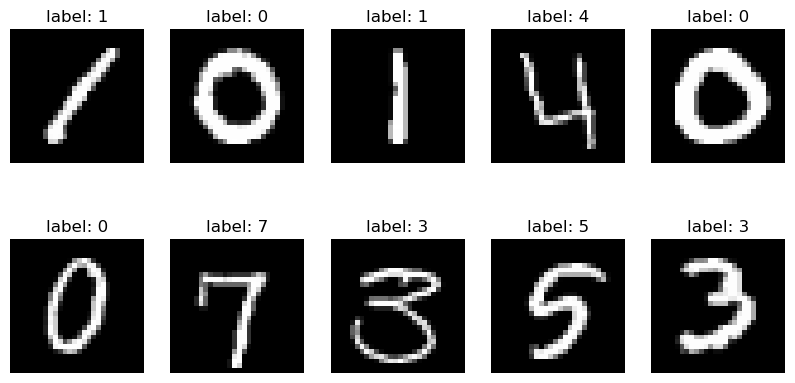

In [5]:
plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(X.values[i].reshape(28, 28), cmap='gray')
    plt.title(f'label: {y[i]}')
    plt.axis('off')
plt.show()

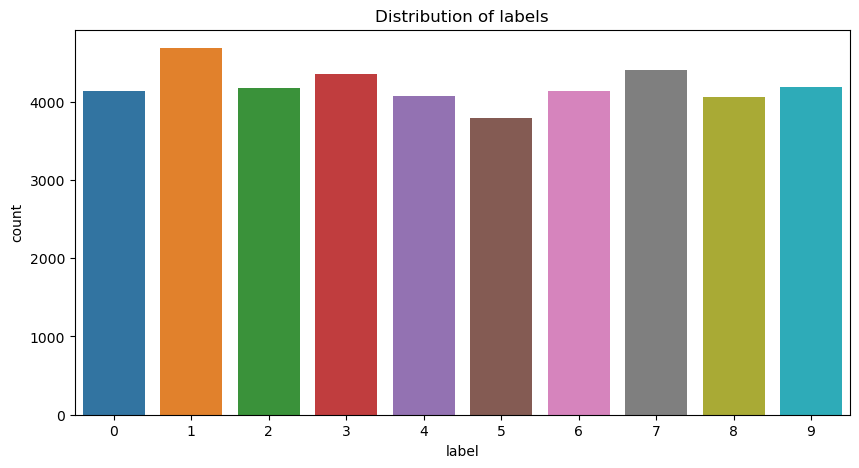

In [6]:
plt.figure(figsize=(10, 5))
plt.title('Distribution of labels')
sns.countplot(data=train, x='label')
plt.show()

In [7]:
pd.DataFrame(X.isnull().sum(), columns=['missing pixels']).sort_values(by='missing pixels', ascending=False).head()

,missing pixels
pixel0,0
pixel515,0
pixel517,0
pixel518,0
pixel519,0


In [8]:
pd.DataFrame(y, columns=['missing labels']).isnull().sum()

missing labels    0.0
dtype: float64

In [9]:
X /= 255.0

In [10]:
X = X.values.reshape(-1, 28, 28, 1)

X.shape

(70000, 28, 28, 1)

In [11]:
y = to_categorical(y, num_classes=10)

y.shape

(42000, 10)

In [12]:
X_train = X[:train.shape[0]].astype('float32')
X_test = X[train.shape[0]:].astype('float32')
y_train = y.astype('int32')

X_train.shape, X_test.shape, y_train.shape

((42000, 28, 28, 1), (28000, 28, 28, 1), (42000, 10))

In [13]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42, stratify=y_train, shuffle=True)

X_train.shape, X_val.shape, y_train.shape, y_val.shape

((37800, 28, 28, 1), (4200, 28, 28, 1), (37800, 10), (4200, 10))

In [14]:
model = Sequential([
    Conv2D(32, (5, 5), padding='same', activation=relu, input_shape=(28, 28, 1)),
    Conv2D(32, (5, 5), padding='same', activation=relu),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    Conv2D(64, (3, 3), padding='same', activation=relu),
    Conv2D(64, (3, 3), padding='same', activation=relu),
    MaxPooling2D((2, 2), strides=(2, 2)),
    Dropout(0.25),
    Flatten(),
    Dense(256, activation=relu),
    Dropout(0.5),
    Dense(10, activation=softmax)
])

In [15]:
model.compile(optimizer=Adam(), loss=CategoricalCrossentropy(), metrics=['accuracy'])

In [16]:
lr_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=3, verbose=1, factor=0.5, min_lr=0.00001)

In [17]:
datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=False,
    vertical_flip=False
)

In [18]:
datagen.fit(X_train)

In [19]:
history = model.fit(datagen.flow(X_train, y_train, batch_size=86), epochs=30, validation_data=(X_val, y_val), callbacks=[lr_reduction], verbose=1, steps_per_epoch=X_train.shape[0] // 86)

Epoch 1/30


2023-08-26 10:06:28.523778: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


439/439 [==============================] - 20s 32ms/step - loss: 0.4272 - accuracy: 0.8620 - val_loss: 0.0929 - val_accuracy: 0.9769 - lr: 0.0010
Epoch 2/30
439/439 [==============================] - 13s 29ms/step - loss: 0.2119 - accuracy: 0.9415 - val_loss: 0.1979 - val_accuracy: 0.9440 - lr: 0.0010
Epoch 3/30
439/439 [==============================] - 14s 31ms/step - loss: 0.2085 - accuracy: 0.9512 - val_loss: 0.3683 - val_accuracy: 0.9138 - lr: 0.0010
Epoch 4/30
439/439 [==============================] - ETA: 0s - loss: 0.4472 - accuracy: 0.9084
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
439/439 [==============================] - 13s 30ms/step - loss: 0.4472 - accuracy: 0.9084 - val_loss: 0.2236 - val_accuracy: 0.9445 - lr: 0.0010
Epoch 5/30
439/439 [==============================] - 14s 31ms/step - loss: 0.1928 - accuracy: 0.9544 - val_loss: 0.1499 - val_accuracy: 0.9671 - lr: 5.0000e-04
Epoch 6/30
439/439 [==============================] - 13s 29m

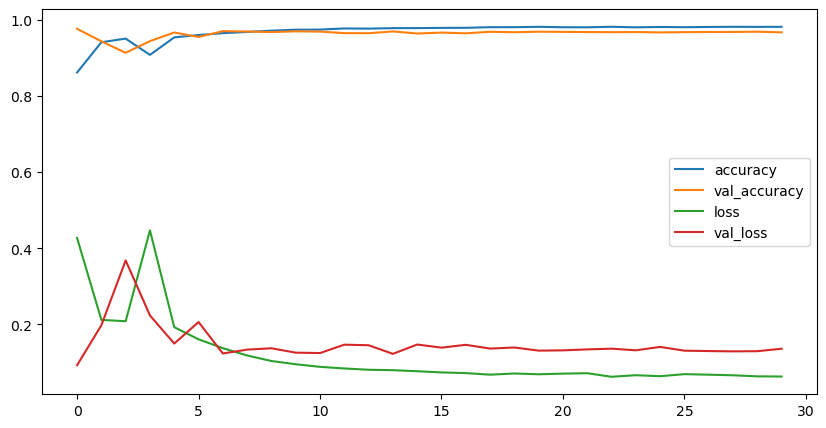

In [20]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

In [21]:
y_pred = model.predict(X_test)

875/875 [==============================] - 2s 2ms/step


In [22]:
submission = pd.DataFrame({'ImageId': range(1, 28001), 'Label': y_pred.argmax(axis=1)})

In [23]:
submission.to_csv('/kaggle/working/submission.csv', index=False)